<a href="https://colab.research.google.com/github/Ajay-user/DataScience/blob/master/Notes/Text_classification_with_an_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Trains a recurrent neural network on the IMDB large movie review dataset for sentiment analysis.**


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

## Create a helper function to plot graphs

In [2]:
def plot_graph(history, metric):
  plt.plot(history[metric])
  plt.plot(history['val_'+metric])
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val'+metric])

## Setup input pipeline
The IMDB large movie review dataset is a binary classification dataset—all the reviews have either a positive or negative sentiment.

Download the dataset using TFDS.

In [4]:
dataset ,info = tfds.load(name='imdb_reviews', as_supervised=True, with_info=True)

In [6]:
training_dataset, testing_dataset = dataset['train'], dataset['test']

In [7]:
print('Training dataset spec',training_dataset.element_spec)
print('Testing dataset spec',testing_dataset.element_spec)

Training dataset spec (TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
Testing dataset spec (TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


Initially this returns a dataset of (text, label pairs):

In [8]:
for example_text, example_label in training_dataset.take(1):
  print('Review:',example_text)
  print('Label:',example_label)

Review: tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
Label: tf.Tensor(0, shape=(), dtype=int64)


Next shuffle the data for training and create batches of these (text, label) pairs:

In [9]:

BUFFER_SIZE = 10000
BATCH_SIZE = 64

training_dataset = training_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
testing_dataset = testing_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
example_text_batch , example_label_batch = next(iter(training_dataset))

for i in range(3):
  print('Review:', example_text_batch[i])
  print('Label:', example_label_batch[i])

Review: tf.Tensor(b'This movie is very entertaining, and any critique is based on personal preferences - not the films quality. Other than the common excessive profanity in some scenes by Murphy, the film is a great vehicle for his type of humor. It has some pretty good special effects, and exciting action scenes.<br /><br />As a finder of lost children, Murphy\'s character starts off looking for a missing girl, which leads him on the path for which others believe he was "chosen" - - to protect the Golden Child. The young boy is born as an enlightened one, destined to save the world from evil forces, but whose very life is in danger, if not for the help of Murphy, and his beautiful, mysterious and mystical helper/guide/protector.<br /><br />Also, there are moments of philosophical lessons to challenge the audience members who are interested in pondering deep thoughts. One such scene is where the Golden Child, that Murphy\'s character is solicited to protect, is tested by the monks of t

## Create the text encoder
The raw text loaded by tfds needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. 

In [11]:
import re
import string

In [16]:
def custom_standardization(text):
  lowercase = tf.strings.lower(text)
  stripped_html = tf.strings.regex_replace(lowercase, "<[^>]+>", ' ')
  return tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation), '')

In [17]:
# eg: standardization
print('Text before standardization \n',example_text_batch[0])
print('Text after standardization \n',custom_standardization(example_text_batch[0]))

Text before standardization 
 tf.Tensor(b'This movie is very entertaining, and any critique is based on personal preferences - not the films quality. Other than the common excessive profanity in some scenes by Murphy, the film is a great vehicle for his type of humor. It has some pretty good special effects, and exciting action scenes.<br /><br />As a finder of lost children, Murphy\'s character starts off looking for a missing girl, which leads him on the path for which others believe he was "chosen" - - to protect the Golden Child. The young boy is born as an enlightened one, destined to save the world from evil forces, but whose very life is in danger, if not for the help of Murphy, and his beautiful, mysterious and mystical helper/guide/protector.<br /><br />Also, there are moments of philosophical lessons to challenge the audience members who are interested in pondering deep thoughts. One such scene is where the Golden Child, that Murphy\'s character is solicited to protect, is te

Text vectoriztion layer
* standardize
* tokenize
* vectorize 

In [18]:
VOCAB_SIZE = 1000

encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE, standardize=custom_standardization)

In [19]:
# create a text-only dataset and call adapt on it 
text_ds = training_dataset.map(lambda text,label:text)

In [20]:
encoder.adapt(text_ds)

In [22]:
print('Length of vocabulary', len(encoder.get_vocabulary()))
print('First five words of vocabulary', encoder.get_vocabulary()[:5])

Length of vocabulary 1000
First five words of vocabulary ['', '[UNK]', 'the', 'and', 'a']


Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [27]:
for i in range(3):
  print('Text before encoding \n',example_text_batch[i])
  print('Text after encoding \n',encoder(example_text_batch)[i])

Text before encoding 
 tf.Tensor(b'This movie is very entertaining, and any critique is based on personal preferences - not the films quality. Other than the common excessive profanity in some scenes by Murphy, the film is a great vehicle for his type of humor. It has some pretty good special effects, and exciting action scenes.<br /><br />As a finder of lost children, Murphy\'s character starts off looking for a missing girl, which leads him on the path for which others believe he was "chosen" - - to protect the Golden Child. The young boy is born as an enlightened one, destined to save the world from evil forces, but whose very life is in danger, if not for the help of Murphy, and his beautiful, mysterious and mystical helper/guide/protector.<br /><br />Also, there are moments of philosophical lessons to challenge the audience members who are interested in pondering deep thoughts. One such scene is where the Golden Child, that Murphy\'s character is solicited to protect, is tested by

With the default settings, the process is not completely reversible. There are three main reasons for that:

* The default value for preprocessing.TextVectorization's standardize argument is "lower_and_strip_punctuation".
* The limited vocabulary size
* The lack of character-based fallback results in some unknown tokens.

In [48]:
vocab = np.array(encoder.get_vocabulary())

for i in range(3):
  print('Text before encoding: \n',example_text_batch[i])
  print('Text after encoding: \n',encoder(example_text_batch[i]))
  print('Reverse the encoding: \n', ' '.join(vocab[encoder(example_text_batch[i]).numpy()]))
  print('\n')

Text before encoding: 
 tf.Tensor(b'This movie is very entertaining, and any critique is based on personal preferences - not the films quality. Other than the common excessive profanity in some scenes by Murphy, the film is a great vehicle for his type of humor. It has some pretty good special effects, and exciting action scenes.<br /><br />As a finder of lost children, Murphy\'s character starts off looking for a missing girl, which leads him on the path for which others believe he was "chosen" - - to protect the Golden Child. The young boy is born as an enlightened one, destined to save the world from evil forces, but whose very life is in danger, if not for the help of Murphy, and his beautiful, mysterious and mystical helper/guide/protector.<br /><br />Also, there are moments of philosophical lessons to challenge the audience members who are interested in pondering deep thoughts. One such scene is where the Golden Child, that Murphy\'s character is solicited to protect, is tested b

## Create the model

<img src='https://www.tensorflow.org/text/tutorials/images/bidirectional.png'/>

* This model can be build as a `tf.keras.Sequential`.

* The first layer is the encoder, which converts the text to a sequence of token indices.

* After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

* This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense layer`.

* A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

* The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

* The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.

* The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

* After the RNN has converted the sequence to a single vector the two layers.Dense do some final processing, and convert from this vector representation to a single logit as the classification output.

In [49]:
model = tf.keras.Sequential([
                             encoder,
                             tf.keras.layers.Embedding(VOCAB_SIZE+1, 64, mask_zero=True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states.

The embedding layer uses masking to handle the varying sequence-lengths. All the layers after the Embedding support masking:

In [50]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [54]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

predictions = model.predict([sample_text])
print('Prediction:',predictions)

Prediction: [[0.00705884]]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [57]:
sample_padding = 'padding_test'*2000

predictions = model.predict([sample_text, sample_padding])
print('Prediction:',predictions)

Prediction: [[ 0.00705884]
 [-0.00571196]]


Compile the Keras model to configure the training process:

In [58]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [61]:
# early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

## Train the model

In [62]:
history = model.fit(x=training_dataset,
                    epochs=10,
                    validation_data=testing_dataset,
                    validation_steps=30,
                    callbacks=[early_stopping])

Epoch 1/10
391/391 [==============================] - 627s 2s/step - loss: 0.3411 - accuracy: 0.8495 - val_loss: 0.3399 - val_accuracy: 0.8370
Epoch 2/10
391/391 [==============================] - 627s 2s/step - loss: 0.3625 - accuracy: 0.8386 - val_loss: 0.3660 - val_accuracy: 0.8385


In [63]:
loss, accuracy = model.evaluate(testing_dataset)
print('Loss',loss)
print('Model accuracy',accuracy)

391/391 [==============================] - 141s 361ms/step - loss: 0.3503 - accuracy: 0.8503
Loss 0.3502994179725647
Model accuracy 0.8502799868583679


## Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [70]:
#  prediction on a new sentence
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

predictions = model.predict([sample_text])

print('Sample :',sample_text)
print('Prediction',predictions,'Positive'if predictions>0.0 else 'Negative')

Sample : The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.
Prediction [[0.09139615]] Positive


There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

In [92]:
def vectorize_text(text,label):
  text = tf.expand_dims(text,-1)
  return encoder(text), label

In [93]:
encoded_train_ds = training_dataset.map(vectorize_text)
encoded_test_ds = testing_dataset.map(vectorize_text)

In [94]:
# config for performance
def config_for_performance(ds):
  ds = ds.cache()
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

encoded_test_ds = config_for_performance(encoded_test_ds)
encoded_train_ds = config_for_performance(encoded_train_ds)

## Stack two or more LSTM layers
Keras recurrent layers have two available modes that are controlled by the return_sequences constructor argument:

If False it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

If True the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape (batch_size, timesteps, output_features)).

Here is what the flow of information looks like with return_sequences=True:

<img src="https://www.tensorflow.org/text/tutorials/images/layered_bidirectional.png" />

In [95]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=VOCAB_SIZE+1, output_dim=64, mask_zero=True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1)
])

In [96]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [97]:
history = model.fit(x=encoded_train_ds, epochs=10, validation_data=encoded_test_ds, validation_steps=30, callbacks=[early_stopping])

Epoch 1/10
391/391 [==============================] - 1251s 3s/step - loss: 0.4409 - accuracy: 0.7759 - val_loss: 0.3471 - val_accuracy: 0.8583
Epoch 2/10
391/391 [==============================] - 1209s 3s/step - loss: 0.3535 - accuracy: 0.8442 - val_loss: 0.3449 - val_accuracy: 0.8516
Epoch 3/10
391/391 [==============================] - 1200s 3s/step - loss: 0.3299 - accuracy: 0.8578 - val_loss: 0.3287 - val_accuracy: 0.8552
Epoch 4/10
391/391 [==============================] - 1191s 3s/step - loss: 0.3022 - accuracy: 0.8667 - val_loss: 0.3374 - val_accuracy: 0.8609


In [100]:
loss, accuracy = model.evaluate(encoded_test_ds)
print('Loss',loss)
print('Model accuracy',accuracy)

391/391 [==============================] - 274s 700ms/step - loss: 0.3321 - accuracy: 0.8576
Loss 0.33213895559310913
Model accuracy 0.8575599789619446


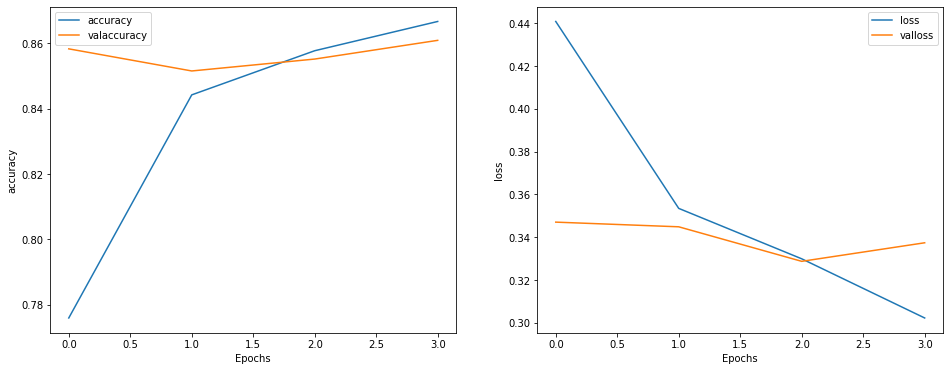

In [103]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graph(history.history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graph(history.history, 'loss')

## Export model

In [104]:
export_model = tf.keras.Sequential([
                                    encoder,
                                    model,
                                    tf.keras.layers.Activation('sigmoid')
])

In [105]:
export_model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])

In [107]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = export_model.predict([sample_text])
print('Sample :',sample_text)
print('Prediction',predictions,'Positive'if predictions>0.5 else 'Negative')

Sample : The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.
Prediction [[0.01567084]] Negative
